# Image features exercise

In this exercise we will show that we can improve our classification performance by training  classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from camalab.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
We will load CIFAR-10 data from disk. You should put the dataset to the right path or change the path in the code

In [3]:
def get_CIFAR10_data(num_training=5000, num_validation=500, num_test=500):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'camalab/datasets/cifar-10-batches-py' # you should change it to your own path, 
                                                      # or put the dataset to this path  
    
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir, 3)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print X_train.shape
print X_val.shape
print X_test.shape

(5000, 32, 32, 3)
(500, 32, 32, 3)
(500, 32, 32, 3)


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as  a color histogram using the hue channel in HSV color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

You should import your `hog` and `color_histogram` functions. Both operate on a single
image and return a feature vector for that image. 

Your function should takes a set of images and a list of feature functions and evaluates each feature function on each image, storing the results in a matrix where each column is the concatenation of all feature vectors for a single image.

In [1]:
import matplotlib
def color_histogram_hsv(im, nbin=10):
  xmin, xmax =0, 255
  ndim = im.ndim
  bins = np.linspace(xmin, xmax, nbin+1)
  hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
  imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins)
  imhist = imhist * np.diff(bin_edges)
  print bins  
  return imhist
def color_histogram_all(images, nbin=10):
    fea = np.zeros( (len(images), nbin) )
    for i in xrange(len(images)):
        fea[i] = color_histogram_hsv(images[i], nbin)
    return fea

In [63]:
X_train_feats1 = color_histogram_all(X_train)
X_val_feats1 = color_histogram_all(X_val)
X_test_feats1 = color_histogram_all(X_test)

错了错了～～不该用hist。。。。。T T

**Question1** 

Use `plt.hist` to plot the features of the X_train[0:4].

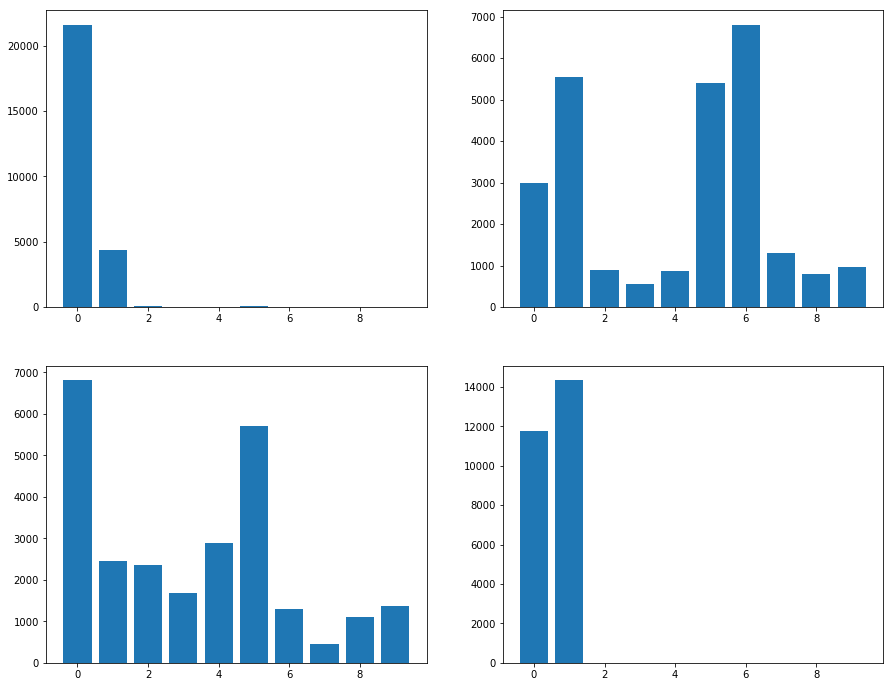

In [72]:
for i in xrange(4):
    plt.subplot(2,2,i+1)
    plt.bar(range(10),X_train_feats1[i])

In [48]:
# 普通版
def hog_feature(image, pixels_per_cell=(4, 4), cells_per_block=(3, 3), orientations = 9):
  
  eps = 1e-5

  image = np.max(image, axis=2) # 最大值法
  image = np.sqrt(image)   # gamma 压缩公式

  sx, sy = image.shape 
  cx, cy = pixels_per_cell 
  bx, by = cells_per_block
    
  # 计算梯度
  gx = np.zeros_like(image, dtype=np.double) 
  gx[:, 1:-1] = image[:, 2:] - image[:, :-2]
  gy = np.zeros_like(image, dtype=np.double)
  gy[1:-1, :] = image[2:, :] - image[:-2, :]
  
  grad_mag = np.sqrt(gx ** 2 + gy ** 2) # 幅值 
  grad_ori = np.arctan(gy/(gx+eps)) * 2 /np.pi * 180 # 方向

  # 总共的cell 行、列
  n_cellsx = sx / cx 
  n_cellsy = sy / cy
  orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))

  # 求直方图
  unit = 360.0 / orientations
  grad_ori = np.array(grad_ori / unit, dtype=np.int)
  for i in xrange(sx):
    for j in xrange(sy):
        orientation_histogram[i/cx, j/cy, grad_ori[i,j]] += grad_mag[i,j]

  # 总共block 行、列
  n_blocksx = (n_cellsx - bx) + 1
  n_blocksy = (n_cellsy - by) + 1
  normalised_blocks = np.zeros((n_blocksy, n_blocksx,
                                  by, bx, orientations))

  for x in range(n_blocksx):
      for y in range(n_blocksy):
          block = orientation_histogram[y:y + by, x:x + bx, :]
          normalised_blocks[y, x, :] = block-block.mean() / np.sqrt(block.sum() ** 2 + eps)
    
  return normalised_blocks.ravel()

In [49]:
# vectorize 版
def hog_feature_vectorize(image, pixels_per_cell=(8, 8), cells_per_block=(3, 3), orientations = 9):
  
  eps = 1e-5

  image = np.max(image, axis=3) # 最大值法
  image = np.sqrt(image)   # gamma 压缩公式

  sx, sy = image[0].shape 
  cx, cy = pixels_per_cell 
  bx, by = cells_per_block
    
  # 计算梯度
  gx = np.zeros_like(image, dtype=np.double) 
  gx[:, :, 1:-1] = image[:, :, 2:] - image[:, :, :-2]
  gy = np.zeros_like(image, dtype=np.double)
  gy[:, 1:-1, :] = image[:, 2:, :] - image[:, :-2, :]
  
  grad_mag = np.sqrt(gx ** 2 + gy ** 2) # 幅值 
  grad_ori = np.arctan(gy/(gx+eps)) * 2 /np.pi * 180 # 方向

  # 总共的cell 行、列
  n_cellsx = sx / cx 
  n_cellsy = sy / cy
  orientation_histogram = np.zeros((len(image), n_cellsx, n_cellsy, orientations))
 
  # 求直方图
  unit = 360.0 / orientations
  grad_ori = np.array(grad_ori / unit, dtype=np.int)
  for i in xrange(sx):
    for j in xrange(sy):
        for k in xrange(len(image)):
            orientation_histogram[k, i/cx, j/cy, grad_ori[k,i,j]] += grad_mag[k,i,j]
        
  # 总共block 行、列
  n_blocksx = (n_cellsx - bx) + 1
  n_blocksy = (n_cellsy - by) + 1
  normalised_blocks = np.zeros((len(image), n_blocksy, n_blocksx,
                                  by, bx, orientations))
    
  for x in range(n_blocksx):
      for y in range(n_blocksy):
          block = orientation_histogram[:, y:y + by, x:x + bx, :]
          bmean = np.mean(block, axis=(1,2,3), keepdims=True)
          bsum = np.sum(block, axis=(1,2,3), keepdims=True)
          normalised_blocks[:, y, x, :] = block-bmean / np.sqrt(bsum ** 2 + eps)
    
  return normalised_blocks.reshape(len(image), -1)

In [50]:
# HOG
X_train_feats2 = hog_feature_vectorize(X_train)
X_val_feats2 = hog_feature_vectorize(X_val)
X_test_feats2 = hog_feature_vectorize(X_test)

In [ ]:
# Fill the code below !
# Concatenating the HOG and color histogram feature vectors.
X_train_feats = None  # you may use the 'np.concatenate' function
X_val_feats = None
X_test_feats = None

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat  
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
# In k-NN, the bias dimension is useless. But you may need it in other classifiers.
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

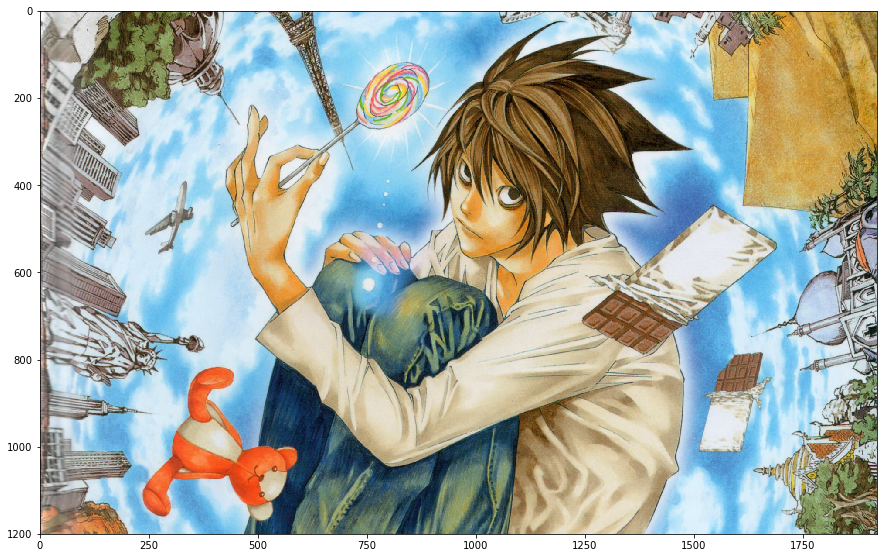

In [67]:
im = img.imread('Death_note18.jpg')
plt.imshow(im) 

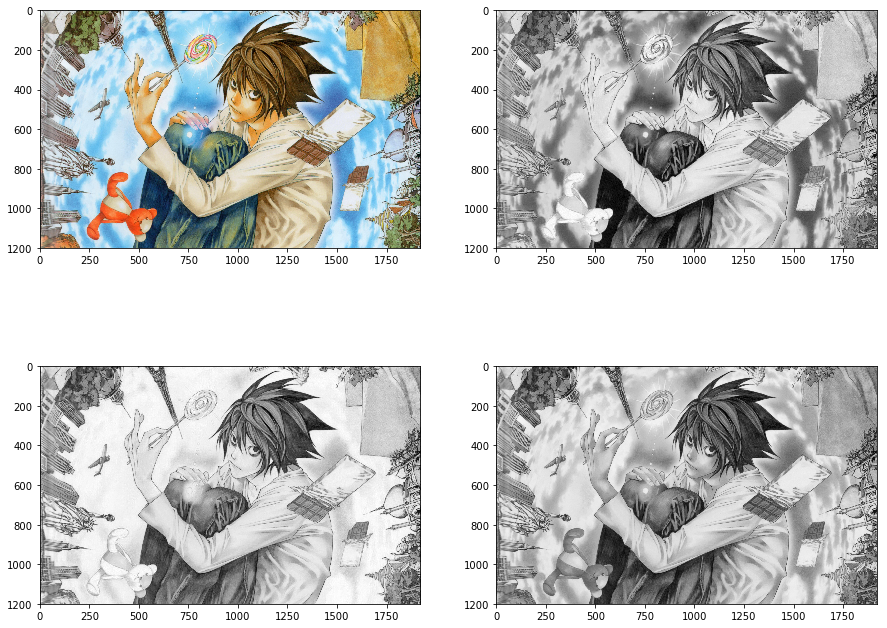

In [39]:
import matplotlib.image as img 
im = img.imread('Death_note18.jpg')
plt.subplot(2,2,1)
plt.imshow(im) 

plt.subplot(2,2,2)
plt.imshow(im[:,:,0])

plt.subplot(2,2,3)
plt.imshow(np.max(im, axis=2))

plt.subplot(2,2,4)
plt.imshow(np.dot(im[...,:3], [0.299, 0.587, 0.144]))

In [43]:
im =np.dot(im[...,:3], [0.299, 0.587, 0.144])

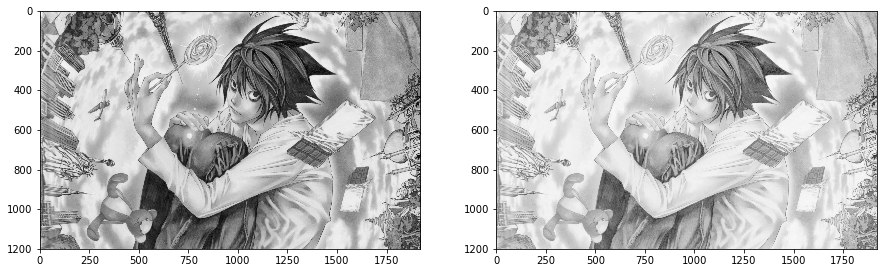

In [45]:
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(np.sqrt(im))

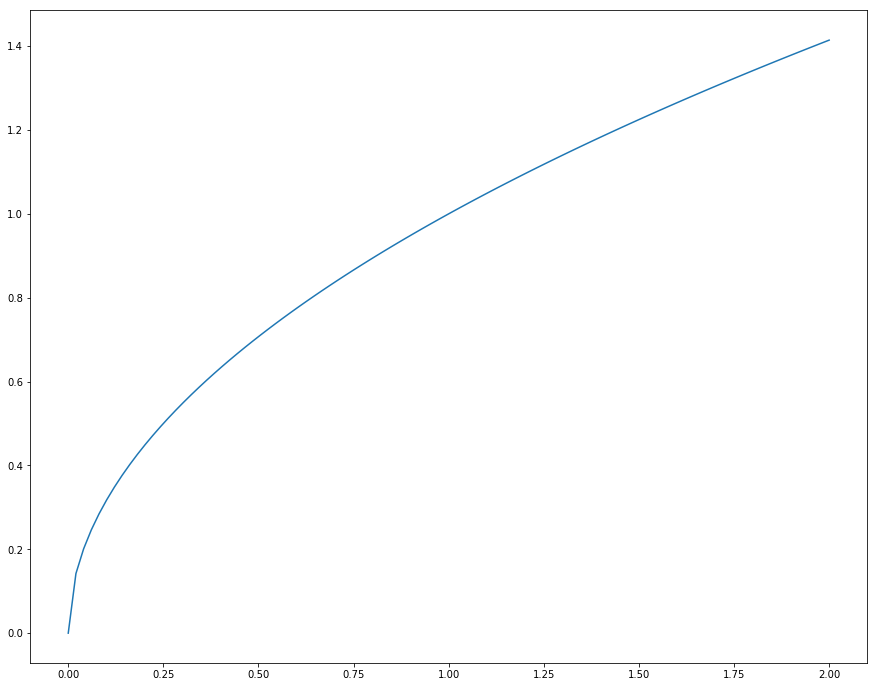

In [66]:
x = np.linspace(0,2,100)
plt.plot(x,np.sqrt(x))

In [51]:
import skimage.feature as F

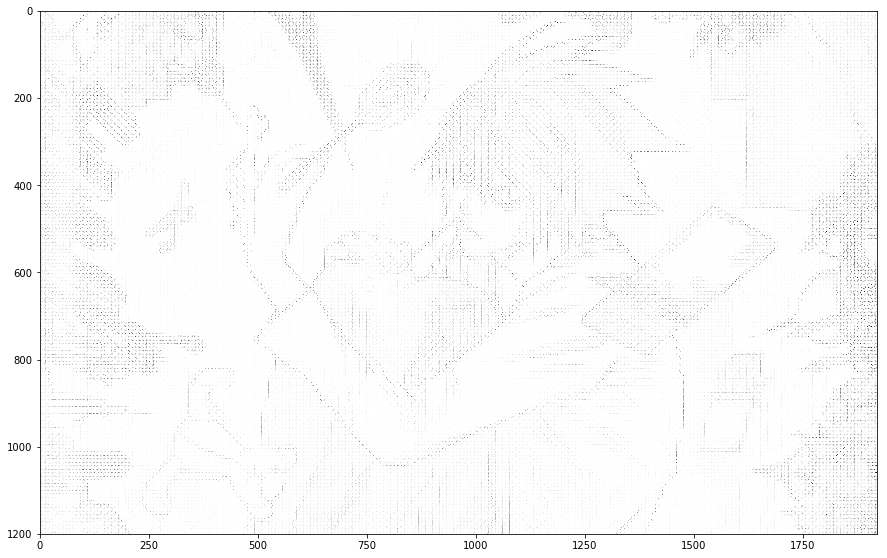

In [56]:
hh,xx = F.hog(im, visualise=True)
plt.imshow(255-xx, )

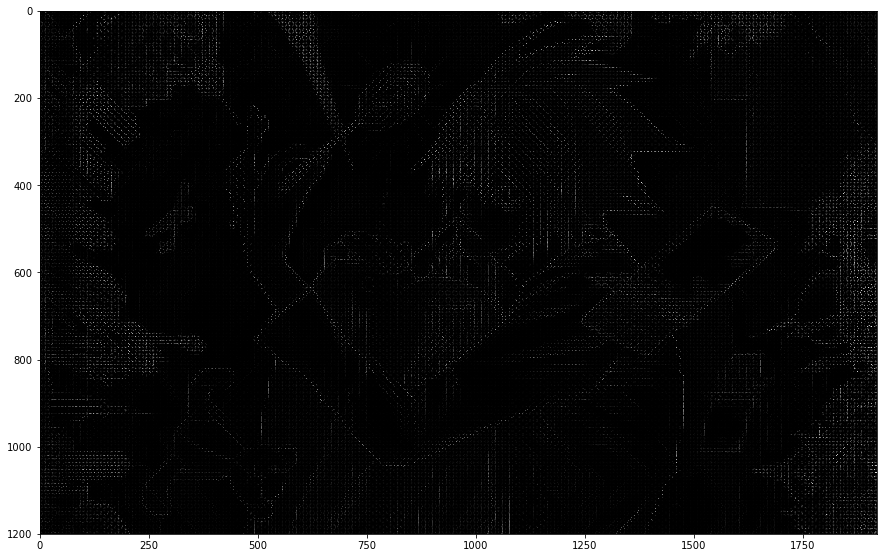

In [59]:
plt.imshow(xx, cmap='hot')